# CTR Estimation using Different Models

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,auc,roc_curve,accuracy_score

In [2]:
#Reading the input files

validation = pd.read_csv('validation.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Analysing the Data

In [3]:
print(f"The total number of records in training dataset: {len(train.index)}")

The total number of records in training dataset: 2430981


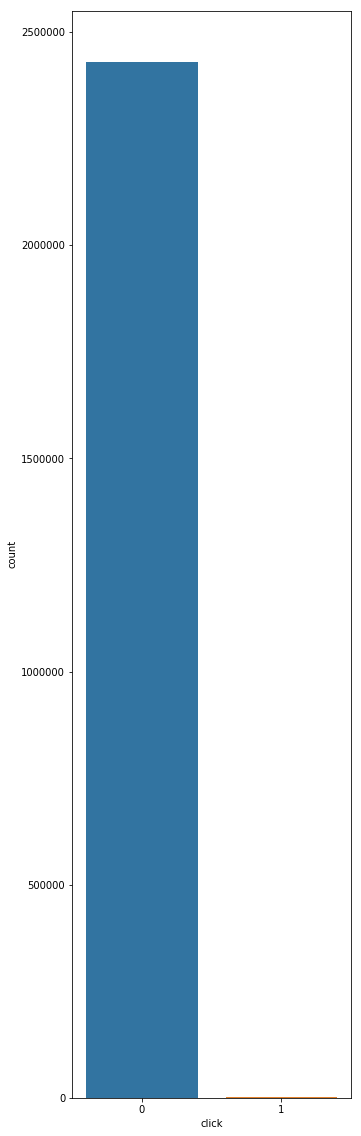

In [9]:
fig = plt.figure(figsize=(5,20))
sns.countplot(x="click", data=train)

It can be easily seen that the data is really unbalanced

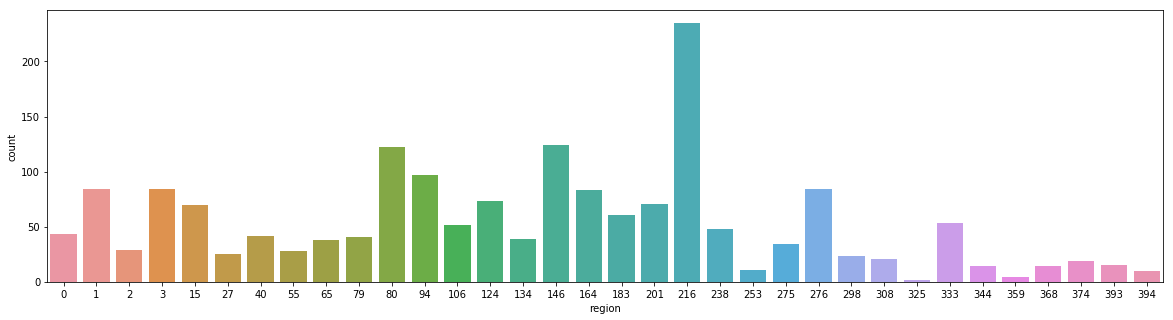

In [8]:
#Count of clicks across all regions

fig = plt.figure(figsize=(20,5))
sns.countplot(x="region",data=train_clicked)

This plot shows the number of clicks produced from different regions

In [9]:
fig = plt.figure(figsize=(500,50))
sns.countplot(x="city",data=train_clicked)

This plot shows the number of clicks produced from different regions

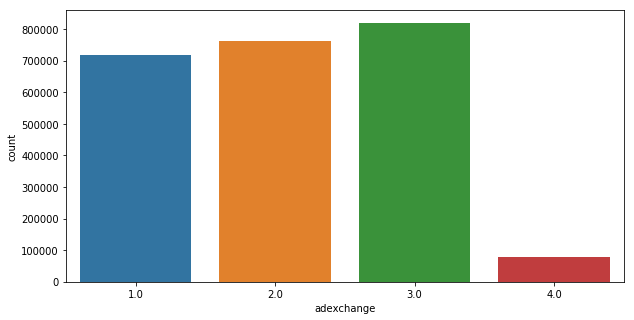

In [10]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x="adexchange",data=train)

This plot shows the number of bids generated by different adexchanges

This plot shows the number of clicks produced for ads generated by different adexchanges

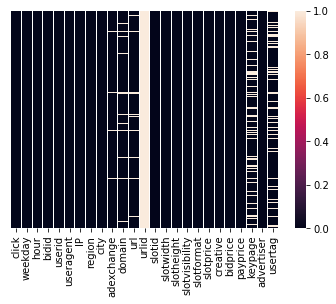

In [13]:
# Data Cleansing/Data Wrangling

list(train.columns)

sns.heatmap(train.isnull(),yticklabels=False)

We can see here that urlid column consists of only null values, so we cab surely drop this column. 

# Splitting the dataset into input and output/labels

In [3]:
# Predict CTR
X_train = train.drop(['click','bidid','userid','IP','domain',
                'url','urlid','slotid','creative','bidprice','payprice','keypage'], axis=1)
y_train = train.click

X_val = validation.drop(['click','bidid','userid','IP','domain',
                'url','urlid','slotid','creative','bidprice','payprice','keypage'], axis=1)
y_val = validation.click
X_test = test.drop(['bidid','userid','IP','domain',
                'url','urlid','slotid','creative','keypage'], axis=1)

# Feature Engineering/Preparing Data for Feeding into the Model

## Encoding slotprice into buckets

In [4]:
def encode_slotprice(X):
    bins = pd.DataFrame()
    bins['slotprice_bins'] = pd.cut(X.slotprice.values,5, labels=[1,2,3,4,5])

    X = pd.concat([X,bins],axis=1)
    X = pd.concat([X,pd.get_dummies(X.slotprice_bins,prefix='slotprice')],axis=1)

    X = X.drop('slotprice',axis=1)
    X = X.drop('slotprice_bins',axis=1)
    bins.pop('slotprice_bins')
    return X

## Encoding user tags

In [5]:
def encode_usertag(X):
    a = pd.DataFrame(X.usertag.str.split(',').tolist())
    usertag_df = pd.DataFrame(a)
    usertag_df2 = pd.get_dummies(usertag_df,prefix='usertag')
    usertag_df2 = usertag_df2.groupby(usertag_df2.columns, axis=1).sum()
    X = pd.concat([X, usertag_df2], axis=1)
    X = X.drop('usertag', axis=1)
    return X

## Splitting user agent into OS and browser

In [ ]:
def encode_useragent(X):
    df = pd.DataFrame(X.useragent.str.split('_',1).tolist(),
                                   columns = ['OS','browser'])
    X = pd.concat([X,df],axis=1)

    # 3. Encode OS
    X = pd.concat([X,pd.get_dummies(X.OS,prefix='OS')],axis=1)
    X = X.drop('OS',axis=1)

    # 4. Encode browser
    X = pd.concat([X,pd.get_dummies(X.browser,prefix='browser')],axis=1)
    X = X.drop('browser',axis=1)
    
    X = X.drop('useragent',axis=1)
    return X

## Using one-hot encoding to handle categorical data

In [ ]:
def one_hot_encoding(X):
    wkday=pd.get_dummies(X["weekday"],prefix="Day", drop_first=True)
    hr=pd.get_dummies(X["hour"],prefix="Hour",drop_first=True)
    rgn=pd.get_dummies(X["region"],prefix="Region",drop_first=True)
    cty=pd.get_dummies(X["city"],prefix="City",drop_first=True)
    adxchange=pd.get_dummies(X["adexchange"],prefix="Adex",dummy_na=True,drop_first=True)
    slt_ht=pd.get_dummies(X["slotheight"],prefix="Slt_Ht",drop_first=True)
    slt_wd=pd.get_dummies(X["slotwidth"],prefix="Slt_Wd",drop_first=True)
    slt_vis=pd.get_dummies(X["slotvisibility"],prefix="Slt_Vis",drop_first=True)
    slt_fmt=pd.get_dummies(X["slotformat"],prefix="Slt_Fmt",drop_first=True)
    advertisr=pd.get_dummies(X["advertiser"],prefix="Advertisr",drop_first=True)
    X = pd.concat([X,wkday,hr,rgn,cty,adxchange,slt_ht,slt_wd,slt_vis,slt_fmt,advertisr],axis=1)
    X = encode_slotprice(X)
    X = encode_useragent(X)
    X.usertag=X.usertag.fillna("999,99")
    X = encode_usertag(X)
    X.drop(["weekday","hour","region","city","adexchange","slotheight","slotwidth","slotvisibility","slotformat",
                 "advertiser"],axis=1,inplace=True)
    return X

## Encoding train,validation and test dataset

In [ ]:
start_fit = time.time()
print("Started encoding for train,validation and test dataset")
X_train = one_hot_encoding(X_train)
X_val = one_hot_encoding(X_val)
X_test = one_hot_encoding(X_test)
print("Encoding finished in %s minutes" % round(((time.time() - start_fit)/60),2))

Started encoding for train,validation and test dataset


# Implementing LogisticRegression Model for pCTR

In [9]:
# Hyperparameter tuning
# Model ~ Logistic Regression

def tune_logreg():
    params = {'C' :[0.0001,0.001,0.01,0.1]}
    lr = LogisticRegression(class_weight='balanced')    
    strk = StratifiedKFold(3, random_state=2048, shuffle=True)
    
    gr = GridSearchCV(lr, params, scoring='roc_auc', cv=strk, verbose=3)
    gr.fit(X_train, y_train)
    return gr.cv_results_

# Switch to True to tune
if True:
    lr_results = tune_logreg()

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.0001 ........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ............... C=0.0001, score=0.8159461748408064, total= 2.2min
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................ C=0.0001, score=0.827809784049679, total= 2.2min
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ............... C=0.0001, score=0.8135010865030545, total= 2.1min
[CV] C=0.001 .........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................. C=0.001, score=0.81943546089747, total= 2.7min
[CV] C=0.001 .........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................ C=0.001, score=0.8351437440126908, total= 3.0min
[CV] C=0.001 .........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................ C=0.001, score=0.8161335697041622, total= 2.7min
[CV] C=0.01 ..........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................. C=0.01, score=0.8025298649242137, total= 3.5min
[CV] C=0.01 ..........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................. C=0.01, score=0.8261466569117756, total= 3.8min
[CV] C=0.01 ..........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ................. C=0.01, score=0.7976863510591616, total= 4.1min
[CV] C=0.1 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................. C=0.1, score=0.7844768366366146, total= 5.8min
[CV] C=0.1 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................. C=0.1, score=0.8110321529556209, total= 6.4min
[CV] C=0.1 ...........................................................


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................. C=0.1, score=0.7723158780920422, total= 6.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 51.4min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
# Best params
min_idx = np.argmax(lr_results['mean_test_score'])
lr_results['params'][min_idx]

{'C': 0.001}

In [27]:
tuning_lr_df = pd.DataFrame(lr_results)
tuning_lr_df = tuning_lr_df[['rank_test_score','param_C','mean_fit_time','mean_test_score']]
tuning_lr_df.columns = ['Rank','Learning Rate','Mean Time','Mean AUC Score']
tuning_lr_df

,Rank,Learning Rate,Mean Time,Mean AUC Score
0,2,0.0001,117.857248,0.819086
1,1,0.001,157.014226,0.823571
2,3,0.01,216.090485,0.808788
3,4,0.1,361.135658,0.789275


We got C=0.001 as the best value for learning rate. Hence we used this value to run our LogisticRegression model.

In [10]:
logmodel=LogisticRegression(class_weight='balanced', C=0.001)
start_fit = time.time()
print("Started fitting")
logmodel.fit(X_train,y_train)
print("Fitting finished in %s minutes" % round(((time.time() - start_fit)/60),2))

Started fitting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting finished in 4.16 minutes


# Testing the Model

In [11]:
predictions_val=logmodel.predict(X_val)
classification_report(y_val,predictions_val)

'              precision    recall  f1-score   support\n\n           0       1.00      0.83      0.91    303723\n           1       0.00      0.71      0.01       202\n\n   micro avg       0.83      0.83      0.83    303925\n   macro avg       0.50      0.77      0.46    303925\nweighted avg       1.00      0.83      0.90    303925\n'

In [12]:
confusion_matrix(y_val,predictions_val)

array([[251151,  52572],
       [    59,    143]])

In [13]:
accuracy_score(y_val,predictions_val)

0.8268289874146583

# pCTR Estimation on Validation

In [14]:
pCTR_val=pd.DataFrame(logmodel.predict_proba(X_val))
pred_val=list(pCTR_val[1])

In [21]:
# re calibrated predictions
# q = p / (p + (1-p) / w

pred_val =[]
pred_test=[]

a = len(train) / 2 * np.bincount(train.click)
w = a[1] / a[0]

for p in pCTR_val[1]:
    pred_val.append( p / (p + ((1-p)/w)))

#for p in pCTR_test[1]:
   # pred_test.append( p / (p + ((1-p)/w)))

In [22]:
# Model AUC score
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve([click for click in validation.click], pred_val)
print('AUC accuracy:',metrics.auc(fpr, tpr))

AUC accuracy: 0.8504592903063086


In [23]:
# Save pCTR values in file
pred_val_pd=pd.concat([validation.bidid,pd.Series(pred_val)],axis=1)
pred_val_pd.to_csv('pctr_val_logreg.csv',index=False)

# pCTR Estimation on Test

In [17]:
# pCTR Estimation on test dataset

pCTR_test=pd.DataFrame(logmodel.predict_proba(X_test))
pred_test=list(pCTR_test[1])

# Save pCTR values in file
pd.DataFrame(pred_test).to_csv('pctr_test_logreg.csv')

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=42))
select.fit(X_train, y_train)
X_train_s = select.transform(X_train)
print('The shape of X_train is: ', X_train.shape)
print('The shape of X_train_s is ', X_train_s.shape)

In [ ]:
X_val_s = select.transform(X_val)
X_test_s = select.transform(X_test)

# Random Forest Classifier

## Model Training

In [ ]:
rf=RandomForestClassifier(n_jobs=4,n_estimators=2500, class_weight='balanced',max_depth=11, max_features=40)
start_fit = time.time()
print("Started fitting")
rf=rf.fit(X_train_s,y_train)
print("Fitting finished in %s minutes" % round(((time.time() - start_fit)/60),2))

## CTR Prediction on Validation

In [ ]:
pCTR_val_rf=pd.DataFrame(rf.predict_proba(X_val_s))

# AUC accuracy score

fpr, tpr, thresholds = metrics.roc_curve(y_val, pCTR_val_rf[1])
print('AUC accuracy:',metrics.auc(fpr, tpr))

#Saving the values

pred_val_rf=list(pCTR_val_rf[1])
pred_val_rf_pd=pd.concat([validation.bidid,pd.Series(pred_val_rf)],axis=1)
pred_val_rf_pd.to_csv('pctr_val_rf.csv',index=False)

## CTR Prediction on Test

In [ ]:
pCTR_test_rf=pd.DataFrame(rf.predict_proba(X_test_s))
pred_test_rf=list(pCTR_test_rf[1])

pred_test_rf_pd=pd.concat([test.bidid,pd.Series(pred_test_rf)],axis=1)
pred_test_rf_pd.to_csv('pctr_test_rf.csv',index=False)

## Analysis of pCTR models

In [40]:
# ROC curves for the pCTR estimators
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline



# Load LR pctr
lr_pctr = pd.DataFrame()
lr_pctr = lr_pctr.from_csv('pctr_val_logreg.csv')
lr_pctr=pd.DataFrame(lr_pctr['pctr'].values)
# Load RF pctr
rf_pctr = pd.DataFrame()
rf_pctr = rf_pctr.from_csv('pctr_val_rf.csv')
rf_pctr = pd.DataFrame(rf_pctr['pctr'].values)
lr_pctr = lr_pctr[:40000]
rf_pctr = rf_pctr[:40000]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  from ipykernel import kernelapp as app


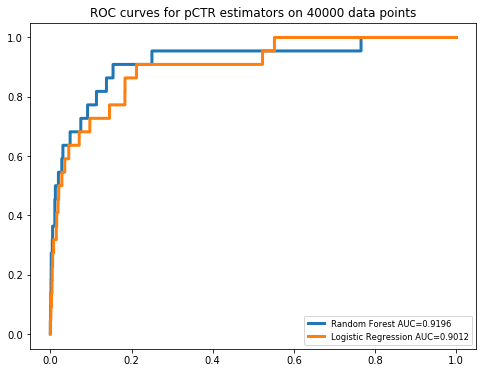

In [45]:
from sklearn import metrics
pctr_list =[rf_pctr,lr_pctr]
rocaucs_list=[]
for pctr in pctr_list:
    fpr, tpr, thresholds = metrics.roc_curve([click for click in validation[:40000].click], pctr)
    roc_auc = metrics.auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])


f, axes = plt.subplots(1, figsize=(8, 6))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Random Forest','Logistic Regression']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC curves for pCTR estimators on 40000 data points')
plt.show()